In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import sys

sys.argv=['']
del sys

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args()
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 2048),
            nn.Linear(2048, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("/home/zhizuo/271B/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "/home/zhizuo/271B/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

D_loss = np.zeros(opt.n_epochs)
G_loss = np.zeros(opt.n_epochs)
for epoch in range(opt.n_epochs):
    
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        D_loss[epoch] += d_loss
        G_loss[epoch] += g_loss
        d_loss.backward()
        optimizer_D.step()

        if i == 1:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        #if batches_done % opt.sample_interval == 0:
        if (epoch + 1) % 50 == 0 and epoch >= 1 and i == 1:
            save_image(gen_imgs.data[:25], "images/GAN_%d.png" % epoch, nrow=5, normalize=True)
    D_loss[epoch] /= len(dataloader)
    G_loss[epoch] /= len(dataloader)
    
    if epoch == opt.n_epochs - 1:
        torch.save(generator.state_dict(), 
                  '/home/zhizuo/271B/GAN_g_128_256_512_1024_1536_.pkl')
        torch.save(discriminator.state_dict(), 
                  '/home/zhizuo/271B/GAN_d_512_256_.pkl')


Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=200, sample_interval=400)
[Epoch 0/200] [Batch 1/938] [D loss: 0.624303] [G loss: 0.691134]
[Epoch 1/200] [Batch 1/938] [D loss: 0.270126] [G loss: 1.293734]
[Epoch 2/200] [Batch 1/938] [D loss: 0.119772] [G loss: 3.257386]
[Epoch 3/200] [Batch 1/938] [D loss: 0.364475] [G loss: 1.127154]
[Epoch 4/200] [Batch 1/938] [D loss: 0.173469] [G loss: 2.032750]
[Epoch 5/200] [Batch 1/938] [D loss: 0.212102] [G loss: 2.358183]
[Epoch 6/200] [Batch 1/938] [D loss: 0.213352] [G loss: 2.740530]
[Epoch 7/200] [Batch 1/938] [D loss: 0.296407] [G loss: 1.780870]
[Epoch 8/200] [Batch 1/938] [D loss: 0.459536] [G loss: 0.954760]
[Epoch 9/200] [Batch 1/938] [D loss: 0.379814] [G loss: 1.580950]
[Epoch 10/200] [Batch 1/938] [D loss: 0.316028] [G loss: 1.576888]
[Epoch 11/200] [Batch 1/938] [D loss: 0.364219] [G loss: 1.676588]
[Epoch 12/200] [Batch 1/938] [D loss: 0.385076] [G loss: 1.573862]


[Epoch 121/200] [Batch 1/938] [D loss: 0.427335] [G loss: 1.655545]
[Epoch 122/200] [Batch 1/938] [D loss: 0.405244] [G loss: 1.240759]
[Epoch 123/200] [Batch 1/938] [D loss: 0.305318] [G loss: 1.570625]
[Epoch 124/200] [Batch 1/938] [D loss: 0.327188] [G loss: 1.601640]
[Epoch 125/200] [Batch 1/938] [D loss: 0.434158] [G loss: 1.519595]
[Epoch 126/200] [Batch 1/938] [D loss: 0.382566] [G loss: 1.899565]
[Epoch 127/200] [Batch 1/938] [D loss: 0.427655] [G loss: 1.670800]
[Epoch 128/200] [Batch 1/938] [D loss: 0.392468] [G loss: 1.595762]
[Epoch 129/200] [Batch 1/938] [D loss: 0.367864] [G loss: 1.908250]
[Epoch 130/200] [Batch 1/938] [D loss: 0.352231] [G loss: 2.013667]
[Epoch 131/200] [Batch 1/938] [D loss: 0.333026] [G loss: 1.557532]
[Epoch 132/200] [Batch 1/938] [D loss: 0.264681] [G loss: 1.947615]
[Epoch 133/200] [Batch 1/938] [D loss: 0.329481] [G loss: 1.714652]
[Epoch 134/200] [Batch 1/938] [D loss: 0.323049] [G loss: 2.240488]
[Epoch 135/200] [Batch 1/938] [D loss: 0.378110]

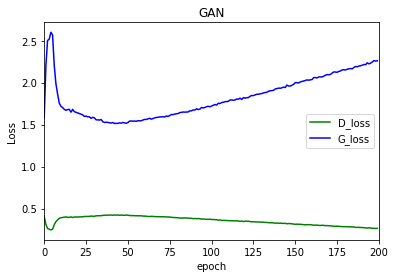

In [3]:
import matplotlib.pyplot as plt
opt.n_epochs = 200
x = np.zeros(opt.n_epochs)
for i in range(opt.n_epochs):
    x[i] = i
plt.figure()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("GAN")
plt.plot(x, D_loss,color='green', label = 'D_loss')
plt.plot(x, G_loss,color='blue', label = 'G_loss')
plt.xlim(0,opt.n_epochs)
plt.legend()
plt.show()

# 